# Chapter 6: Progressive GAN



This Colab / Ipython notebook will walk you through:
1. The code we have seen in the chapter:

  1.1 Progressive Growing & Smoothing in of Higher Resolution Layers
  
  1.2 Minibatch Standard Deviation
  
  1.3 Equalized Learning Rate
  
  1.4 Pixel-wise Feature Normalization
2. Using TensorFlow Hub to download models that generate 128x128 images as we did in the chapter.
3. Extend on this code by looking at what the TF Hub team provide as starter code.

--- 
Let's now start with the imports to write out the pseudo-code from the chapter.

## 1.1  Progressive Growing & Smoothing in of Higher Resolution Layers


We will start with the smoothly merging the parametric upscale and the learned upscale. This is the key to progressive growing, becuase this is the way we "transfer-learn" the lower resolution paramaters onto the higher resolution parameters. This is the key difference between PGGANs and e.g. Laplacian pyramids, if you're familiar.

In [1]:
import tensorflow as tf
import keras as K

2021-07-27 09:23:30.800475: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-27 09:23:30.800526: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def upscale_layer(layer, upscale_factor):
	'''
	Upscales layer (tensor) by the factor (int) where
      the tensor is [group, height, width, channels]
	'''
	height, width = layer.get_shape()[1:3]
	size = (upscale_factor * height, upscale_factor * width)
	upscaled_layer = tf.image.resize(layer, size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
	return upscaled_layer

def smoothly_merge_last_layer(list_of_layers, alpha):
	'''
	Smoothly merges in a layer based on a threshold value alpha.
	This function assumes: that all layers are already in RGB.
	This is the function for the Generator.
	:list_of_layers	:	items should be tensors ordered by size
	:alpha 			: 	float \in (0,1)
	'''
	# Hint!
  # If you are using pure Tensorflow rather than Keras, always remember scope
	last_fully_trained_layer = list_of_layers[-2]
	# now we have the originally trained layer
	last_layer_upscaled = upscale_layer(last_fully_trained_layer, 2)

	# this is the newly added layer not yet fully trained
	larger_native_layer = list_of_layers[-1]

	# This makes sure we can run the merging code
	assert larger_native_layer.get_shape() == last_layer_upscaled.get_shape()

	# This code block should take advantage of broadcasting
	new_layer = (1-alpha) * upscaled_layer + larger_native_layer * alpha

	return new_layer

## 1.2 Minibatch standard deviation
This is explained in much more detail in the book, but simply recall that this is a way to inform the discriminator about how varied the samples in this batch are, so that we avoid mode collapse.

In [3]:
def minibatch_std_layer(layer, group_size=4):
  '''
  Will calculate minibatch standard deviation for a layer.
  Will do so under a pre-specified tf-scope with Keras.
  Assumes layer is a float32 data type. Else needs validation/casting.
  NOTE: there is a more efficient way to do this in Keras, but just for
  clarity and alignment with major implementations (for understanding)
  this was done more explicitly. Try this as an exercise.
  '''
  # Hint!
  # If you are using pure Tensorflow rather than Keras, always remember scope
  # minibatch group must be divisible by (or <=) group_size
  group_size = K.backend.minimum(group_size, tf.shape(input=layer)[0])

  # just getting some shape information so that we can use
  # them as shorthand as well as to ensure defaults
  shape = list(K.int_shape(input))
  shape[0] = tf.shape(input=input)[0]

  # Reshaping so that we operate on the level of the minibatch
  # in this code we assume the layer to be:
  # [Group (G), Minibatch (M), Width (W), Height (H) , Channel (C)]
  # but be careful different implementations use the Theano specific
  # order instead
  minibatch = K.backend.reshape(layer, (group_size, -1, shape[1], shape[2], shape[3]))

  # Center the mean over the group [M, W, H, C]
  minibatch -= tf.reduce_mean(input_tensor=minibatch, axis=0, keepdims=True)
  # Calculate the variance of the group [M, W, H, C]
  minibatch = tf.reduce_mean(input_tensor=K.backend.square(minibatch), axis = 0)
  # Calculate the standard deviation over the group [M,W,H,C]
  minibatch = K.backend.square(minibatch + 1e8)
  # Take average over feature maps and pixels [M,1,1,1]
  minibatch = tf.reduce_mean(input_tensor=minibatch, axis=[1,2,4], keepdims=True)
  # Add as a layer for each group and pixels
  minibatch = K.backend.tile(minibatch, [group_size, 1, shape[2], shape[3]])
  # Append as a new feature map
  return K.backend.concatenate([layer, minibatch], axis=1)

## 1.3 Equalized Learning Rate
This is one of the dark arts parts of the paper. For now, we would treat this simply as an empirical trick that seems to fix the observed problems.

In [4]:
def equalize_learning_rate(shape, gain, fan_in=None):
    '''
    This adjusts the weights of every layer by the constant from
    He's initializer so that we adjust for the variance in the dynamic range
    in different features
    shape   :   shape of tensor (layer): these are the dimensions of each layer.
    For example, [4,4,48,3]. In this case,
        [kernel_size, kernel_size, number_of_filters, feature_maps].
        But this will depend slightly on your implementation.
    gain    :   typically sqrt(2)
    fan_in  :   adjustment for the number of incoming connections as per Xavier's / He's initialization
    '''
    # Default value is product of all the shape dimension minus the feature maps dim -- this gives us the number of incoming connections per neuron
    if fan_in is None: fan_in = np.prod(shape[:-1])
    # This uses He's initialization constant (He et al, 2015)
    std = gain / K.sqrt(fan_in)
    # creates a constant out of the adjustment
    wscale = K.constant(std, name='wscale', dtype=np.float32)
    # gets values for weights and then uses broadcasting to apply the adjustment
    adjusted_weights = K.get_value('layer', shape=shape,
            initializer=tf.compat.v1.initializers.random_normal()) * wscale
    return adjusted_weights

## 1.4 Pixel-wise Feature Normalization 
Again, this is explained more thoroughly in the chapter. But as you can see, the code to code itself is quite short:

In [5]:
def pixelwise_feat_norm(inputs, **kwargs):
	'''
	Uses pixelwise feature normalization as proposed by
	Krizhevsky et at. 2012. Returns the input normalized
	:inputs 	: 	Keras / TF Layers
	'''
	normalization_constant = K.backend.sqrt(K.backend.mean(
					inputs**2, axis=-1, keepdims=True) + 1.0e-8)
	return inputs / normalization_constant

# 2 Running our own PGGAN
Below we can see an example of a generated 128x128 face in just a few lines of code with no training required!

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
2021-07-27 09:23:32.577197: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-07-27 09:23:32.577250: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-07-27 09:23:32.577277: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (522cb8dce1ea): /proc/driver/nvidia/version does not exist
2021-07-27 09:23:32.577560: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-27 09:23:32.6

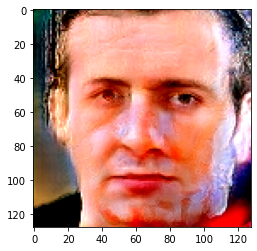

In [6]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

with tf.Graph().as_default():
    # import the progressive GAN from TFHub
    module = hub.Module("https://tfhub.dev/google/progan-128/1")
    # latent dimension that gets
    latent_dim = 512

    # Change the seed to get different faces.
    latent_vector = tf.random.normal([1, latent_dim], seed=1337)

    # Uses module to generate images from the latent space.
    interpolated_images = module(latent_vector)

    # runs the tensorflow session and gets back the image in shape (1,128,128,3)
    with tf.compat.v1.Session() as session:
      session.run(tf.compat.v1.global_variables_initializer())
      image_out = session.run(interpolated_images)

plt.imshow(image_out.reshape(128,128,3))
plt.show()

## 3. Extending on the PGGAN
Here we are including more elaborate examples that were not covered in the chapter, but can give you a sense of the potential uses and hopefully give you some ideas on more advanced applications.

The rest of the code comes from the TensorFlow Hub Authors.

##### Copyright 2018 The TensorFlow Hub Authors.


Licensed under the Apache License, Version 2.0 (the "License");

In [7]:
#@title
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# TF-Hub generative image model

Note: You can run this notebook [live in Colab](https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf_hub_generative_image_module.ipynb) with zero setup.

This Colab demonstrates use of a TF-Hub module based on a generative adversarial network (GAN). The module maps from N-dimensional vectors, called latent space, to RGB images.

Two examples are provided:
* **Mapping** from latent space to images, and
* Given a target image, **using gradient descent to find** a latent vector that generates an image similar to the target image.

In [8]:
# Install the latest Tensorflow version.
!pip install --quiet "tensorflow>=1.7"
# Install TF-Hub.
!pip install tensorflow-hub
# Install imageio for creating animations.
!pip install imageio

In [9]:
#@title Imports and function definitions

import imageio
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import time
from IPython import display
from skimage import transform

# We could retrieve this value from module.get_input_shapes() if we didn't know
# beforehand which module we will be using.
latent_dim = 512


# Interpolates between two vectors that are non-zero and don't both lie on a
# line going through origin. First normalizes v2 to have the same norm as v1.
# Then interpolates between the two vectors on the hypersphere.
def interpolate_hypersphere(v1, v2, num_steps):
  v1_norm = tf.norm(tensor=v1)
  v2_norm = tf.norm(tensor=v2)
  v2_normalized = v2 * (v1_norm / v2_norm)

  vectors = []
  for step in range(num_steps):
    interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
    interpolated_norm = tf.norm(tensor=interpolated)
    interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
    vectors.append(interpolated_normalized)
  return tf.stack(vectors)


# Given a set of images, show an animation.
def animate(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images)
  with open('./animation.gif','rb') as f:
      display.display(display.Image(data=f.read(), height=300))


# Simple way to display an image.
def display_image(image):
  plt.figure()
  plt.axis("off")
  plt.imshow(image)


# Display multiple images in the same figure.
def display_images(images, captions=None):
  num_horizontally = 5
  f, axes = plt.subplots(
      len(images) // num_horizontally, num_horizontally, figsize=(20, 20))
  for i in range(len(images)):
    axes[i // num_horizontally, i % num_horizontally].axis("off")
    if captions is not None:
      axes[i // num_horizontally, i % num_horizontally].text(0, -3, captions[i])
    axes[i // num_horizontally, i % num_horizontally].imshow(images[i])
  f.tight_layout()

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Latent space interpolation

### Random vectors

Latent space interpolation between two randomly initialized vectors. We will use a TF-Hub module [progan-128](https://tfhub.dev/google/progan-128/1) that contains a pre-trained Progressive GAN.

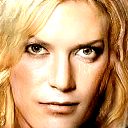

In [10]:
def interpolate_between_vectors():
  with tf.Graph().as_default():
    module = hub.Module("https://tfhub.dev/google/progan-128/1")

    # Change the seed to get different random vectors.
    v1 = tf.random.normal([latent_dim], seed=3)
    v2 = tf.random.normal([latent_dim], seed=1)

    # Creates a tensor with 50 steps of interpolation between v1 and v2.
    vectors = interpolate_hypersphere(v1, v2, 25)

    # Uses module to generate images from the latent space.
    interpolated_images = module(vectors)

    with tf.compat.v1.Session() as session:
      session.run(tf.compat.v1.global_variables_initializer())
      interpolated_images_out = session.run(interpolated_images)

    animate(interpolated_images_out)

interpolate_between_vectors()

## Finding closest vector in latent space
Fix a target image. As an example use an image generated from the module or upload your own.

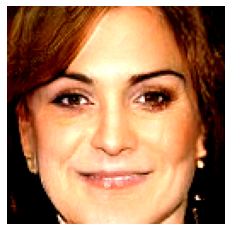

In [11]:
image_from_module_space = True  # @param { isTemplate:true, type:"boolean" }

def get_module_space_image():
  with tf.Graph().as_default():
    module = hub.Module("https://tfhub.dev/google/progan-128/1")
    vector = tf.random.normal([1, latent_dim], seed=4)
    images = module(vector)

    with tf.compat.v1.Session() as session:
      session.run(tf.compat.v1.global_variables_initializer())
      image_out = session.run(images)[0]
  return image_out

def upload_image():
  uploaded = files.upload()
  image = imageio.imread(uploaded[uploaded.keys()[0]])
  return transform.resize(image, [128, 128])

if image_from_module_space:
  target_image = get_module_space_image()
else:
  target_image = upload_image()
display_image(target_image)

After defining a loss function between the target image and the image generated by a latent space variable, we can use gradient descent to find variable values that minimize the loss.

In [12]:
def find_closest_latent_vector(num_optimization_steps):
  images = []
  losses = []
  with tf.Graph().as_default():
    module = hub.Module("https://tfhub.dev/google/progan-128/1")

    initial_vector = tf.random.normal([1, latent_dim], seed=5)

    vector = tf.compat.v1.get_variable("vector", initializer=initial_vector)
    image = module(vector)

    target_image_difference = tf.reduce_sum(
        input_tensor=tf.compat.v1.losses.absolute_difference(image[0], target_image[:,:,:3]))

    # The latent vectors were sampled from a normal distribution. We can get
    # more realistic images if we regularize the length of the latent vector to
    # the average length of vector from this distribution.
    regularizer = tf.abs(tf.norm(tensor=vector) - np.sqrt(latent_dim))

    loss = target_image_difference + regularizer

    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.3)
    train = optimizer.minimize(loss)

    with tf.compat.v1.Session() as session:
      session.run(tf.compat.v1.global_variables_initializer())
      for _ in range(num_optimization_steps):
        _, loss_out, im_out = session.run([train, loss, image])
        images.append(im_out[0])
        losses.append(loss_out)
        print(loss_out)
    return images, losses


result = find_closest_latent_vector(num_optimization_steps=40)

0.6887691
5.607328
5.049135
2.7256722
0.73154074
1.4969449
0.8284965
1.1468741
1.4736884
0.7809495
0.878163
1.2610791
0.8297864
0.5126057
0.76548725
0.28093553
1.013067
1.3111942
0.9581146
0.17515397
0.38840875
0.22780845
0.20012194
0.38048956
0.14732626
0.8286416
0.95285517
0.4996323
0.6415742
0.9430558
0.689232
0.25424325
0.4033826
0.1728288
0.18554884
0.3568522
0.16572407
0.6986712
0.79765916
0.3708174


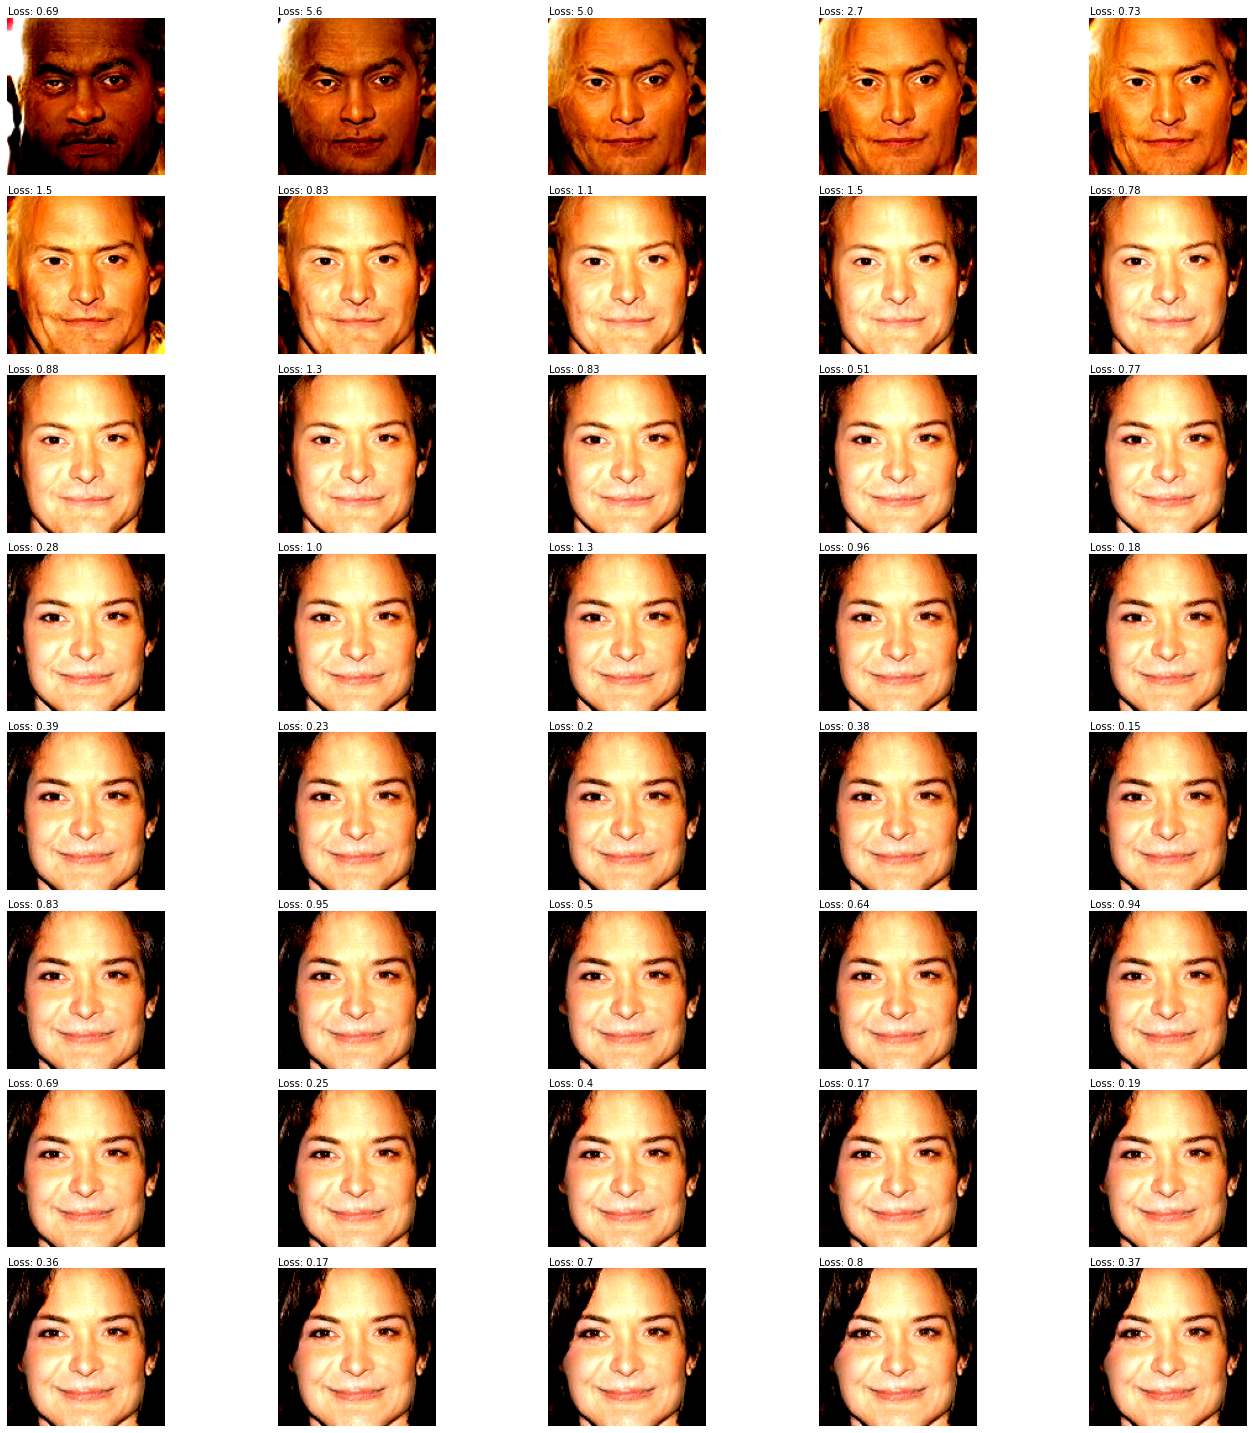

In [13]:
captions = [ f'Loss: {l:.2}' for l in result[1]]
display_images(result[0], captions)

### Playing with the above example
If image is from the module space, the descent is quick and converges to a reasonable sample. Try out descending to an image that is **not from the module space**. The descent will only converge if the image is reasonably close to the space of training images.

How to make it descend faster and to a more realistic image? One can try:
* using different loss on the image difference, e.g. quadratic,
* using different regularizer on the latent vector,
* initializing from a random vector in multiple runs,
* etc.
